In [25]:
import requests
import json
from bs4 import BeautifulSoup
from datetime import datetime
from transformers import pipeline
import matplotlib.pyplot as plt

In [26]:
def scrape_reddit_topics(search_query):
    # Use search endpoint with query
    url = f"https://www.reddit.com/search.json?q={search_query}&sort=relevance"
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.3'
    }
    try:
        # Get search results
        response = requests.get(url, headers=headers)
        data = response.json()
        
        posts_with_comments = []
        
        for post in data['data']['children']:
            post_data = post['data']
            
            # Get comments for this post
            comments_url = f"https://www.reddit.com{post_data['permalink']}.json"
            comments_response = requests.get(comments_url, headers=headers)
            comments_data = comments_response.json()
            
            # Extract comments
            comments = []
            if len(comments_data) > 1:  # Check if there are comments
                for comment in comments_data[1]['data']['children']:
                    if 'body' in comment['data']:
                        comments.append({
                            'author': comment['data'].get('author', '[deleted]'),
                            'body': comment['data']['body'],
                            'score': comment['data'].get('score', 0),
                            'created_utc': datetime.fromtimestamp(comment['data']['created_utc']).isoformat()
                        })
            
            # Combine post and comments data
            posts_with_comments.append({
                'title': post_data['title'],
                'author': post_data['author'],
                'score': post_data['score'],
                'url': post_data['url'],
                'created_utc': datetime.fromtimestamp(post_data['created_utc']).isoformat(),
                'num_comments': post_data['num_comments'],
                'selftext': post_data.get('selftext', ''),
                'comments': comments
            })
        
        # Save to JSON file
            
        return posts_with_comments
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return None

In [27]:
#webscraping particular subreddits
print("Hi! Welcome to the Reddit Web Scraper!")
subreddit = input("Please enter the subreddit you would like to scrape: ")
posts = scrape_reddit_topics(subreddit)

Hi! Welcome to the Reddit Web Scraper!


In [29]:
def extract_posts_and_comments(json_obj):
    texts = []
    for entry in json_obj:
        # Extract post content (selftext)
        if 'selftext' in entry and entry['selftext']:
            texts.append(entry['selftext'])
        
        # Extract comments
        if 'comments' in entry:
            for comment in entry['comments']:
                if 'body' in comment:
                    texts.append(comment['body'])
    return texts

posts_and_comments = extract_posts_and_comments(posts)



In [30]:
#NLP stuff 
classifier = pipeline('sentiment-analysis', model='tabularisai/multilingual-sentiment-analysis')
all_results = []
for text in posts_and_comments:
    text=text[:512]
    result = classifier(text)
    all_results.append(result)
#labels are very positive, positive, neutral, negative, very negative

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


In [38]:

very_positive = 0
positive = 0
neutral = 0
negative = 0
very_negative = 0

for result in all_results:
    if result[0]['label'] == 'Very Positive':
        very_positive += 1
    elif result[0]['label'] == 'Positive':
        positive += 1
    elif result[0]['label'] == 'Neutral':
        neutral += 1
    elif result[0]['label'] == 'Negative':
        negative += 1
    elif result[0]['label'] == 'Very Negative':
        very_negative += 1



Very Positive: 133


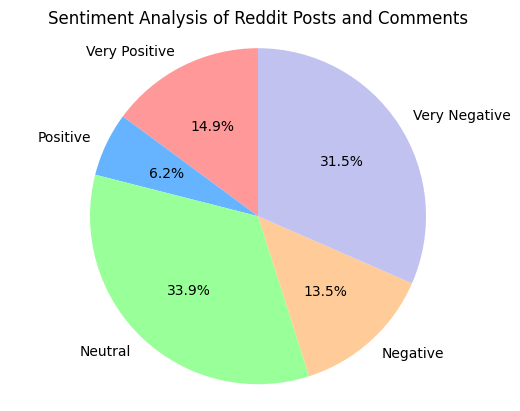

In [39]:
#plotting the data

labels = ['Very Positive', 'Positive', 'Neutral', 'Negative', 'Very Negative']
sizes = [very_positive, positive, neutral, negative, very_negative]
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title('Sentiment Analysis of Reddit Posts and Comments')
plt.show()